# F1 data analysis notebook 
#### @kevinofsydney

Notes:
- The 'KeyError' is because the name of the column gets consumed when it is turned into an index 
- df = pd.merge(df,df2[['Key_Column','Target_Column']],on='Key_Column', how='left')
- RIC driverId is 817
- df.describe() is useful
- oddsportal.com
- race_df['name'].unique()
- http://www.f1-predictor.com/category/data-science/

### To do list
- Automate adding the column labels
- Create a working prototype to predict qualifier results
- Create a working prototype to predict race results

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

## Preprocessing

In [2]:
# Load the files
cir_df = pd.read_csv('circuits_l.csv')
conresult_df = pd.read_csv('constructor_results_l.csv')
constanding_df = pd.read_csv('constructor_standings_l.csv')
con_df = pd.read_csv('constructors_l.csv')
driver_df = pd.read_csv('driver_l.csv')
laptime_df = pd.read_csv('lap_times_l.csv')
quali_df = pd.read_csv('qualifying_l.csv')
race_df = pd.read_csv('races_l.csv')
result_df = pd.read_csv('results_l.csv')
status_df = pd.read_csv('status_l.csv')

# Set the correct indices 
race_df['date'] = pd.to_datetime(race_df['date'], dayfirst=True)

# driver_df.set_index('driverId', inplace=True)
quali_df.set_index('qualifyId', inplace=True)
laptime_df.set_index('raceId', inplace=True)
race_df.set_index('date', inplace=True)
result_df.set_index('resultId', inplace=True)

# race_df.sort_values('raceId', inplace=True)
race_df.sort_index(inplace=True)

# Remove unnecessary columns, or columns I still need to implement processing for
result_df = result_df.drop('number', axis=1)

resultsm_df = result_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']]

def label_points(row):
    if row['positionOrder'] <= 3:
        return 1 #'top3'
    elif row['positionOrder'] > 3 and row['positionOrder'] <= 6:
        return 2 # 'top6'
    elif row['positionOrder'] > 6 and row['positionOrder'] <= 10:
        return 3 #'top10'
    else:
        return 4 #'no_points'

resultsm_df = resultsm_df.merge(race_df[['raceId', 'circuitId']], how='left', on=['raceId'])
resultsm_df['raceresult'] = resultsm_df.apply(label_points, axis=1)
resultsm_df.head(5)

,raceId,driverId,constructorId,grid,positionOrder,circuitId,raceresult
0,900,3,131,3,1,1,1
1,900,825,1,4,2,1,1
2,900,18,1,10,3,1,1
3,900,4,6,5,4,1,2
4,900,822,3,15,5,1,2


In [3]:
# Turning driverId and constructorId from categorical to continuous variables 
# resultsm_df

In [32]:
# Splitting into training and test sets
# data - resultsm_df[['circuitId', 'driverId', 'constructorId', 'grid']]
# target - resultsm_df[['raceresult']]

from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(resultsm_df[['circuitId', 'driverId', 'constructorId', 'grid']],
                                                    resultsm_df[['raceresult']],
                                                    test_size=0.25,
                                                    random_state=1)


from sklearn import svm
clf_svm = svm.SVC(kernel='linear', C=1).fit(data_train, label_train)
clf_svm.score(data_test, label_test)

D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6308492201039861

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
clf_nb = gnb.fit(data_train, label_train)
pred = gnb.fit(data_train, label_train).predict(train_target)

# Print the accuracy score of the model
print("Naive-Bayes accuracy : ",accuracy_score(test_target, pred, normalize = True))

NameError: name 'test_data' is not defined

## Graveyard

In [9]:
# Find a driverId via their code
code = 'RAI'
did = driver_df[ driver_df['code'] == code]['driverId']
print("INFO: driverID for", code, "is:", int(did))

### Return the result for a single driver
resultsm_df[resultsm_df['driverId'] == int(did)].head(20)

resultsm_df['driverId'].nunique()

INFO: driverID for RAI is: 8


45

In [11]:
# Merging the quali, driver_details and results dataframes together
quali_rdf = quali_df[['raceId', 'driverId', 'q1', 'q2', 'q3']]
master = driver_df[['driverId', 'code']].merge(quali_rdf, how='inner', on=['driverId'])
master = master.merge(result_df, how='inner', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])
# master.sort_values(by=['raceId', 'positionOrder']).head(50)
master.head(5)
# Train the model

,driverId,code,raceId,q1,q2,q3,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,HAM,900,01:31.7,01:42.9,01:44.2,131,1,\N,R,19,0,2,\N,\N,2,20,01:49.9,173.636,5
1,1,HAM,901,01:57.2,01:59.0,01:59.4,131,1,1,1,1,25,56,40:26.0,6025974,53,1,01:43.1,193.611,1
2,1,HAM,902,01:35.3,01:33.9,01:33.5,131,2,1,1,1,25,57,39:42.7,5982743,49,2,01:37.1,200.634,1
3,1,HAM,903,01:55.5,01:54.0,01:53.9,131,1,1,1,1,25,54,33:28.3,5608338,42,2,01:41.2,193.916,1
4,1,HAM,904,01:27.2,01:26.2,01:25.2,131,1,1,1,1,25,66,41:05.2,6065155,54,3,01:29.5,187.275,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F409188D08>,
      dtype=object)

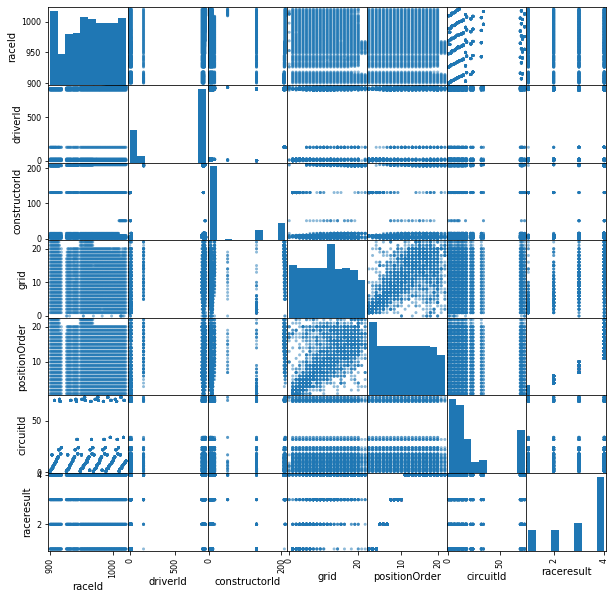

In [12]:
# Replace raceId with circuitId
from pandas.plotting import scatter_matrix
scatter_matrix(resultsm_df[['raceId','driverId','constructorId','grid','positionOrder','circuitId', 'raceresult']], figsize=(10,10))